# Assignment 6: Analysis of Fashion MNIST Dataset

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a standard dataset that is used for evaluation of machine learning models. It contains a total of 70,000 $28\times 28$ greyscale images of different clothing objects, sourced from Zalando. The dataset is split into a training set of 60,000 images and a test set of 10,000 images. The objects are classified into 10 classes as follows:
|Label|Description|
------|------------
|0    |T-shirt/top|
|1    |Trouser    |
|2    |Pullover   |
|3    |Dress      |
|4    |Coat       |
|5    |Sandal     |
|6    |Shirt      |
|7    |Sneaker    |
|8    |Bag        |
|9    |Ankle boot |

In this assignment, we use PyTorch to train neural networks to classify images into aforementioned classes.

## Research consent
We would like to use your answers for research purposes. We are conducting a master thesis where automatic grading of plots is investigated. During this course, the plots will be graded manually. However, we would like to use as many submissions as possible for evaluating the AI-based automatic grader that is being developed as part of the master thesis.

Your submissions will be exported in bulk from CodeGrade and the **Python code** is extracted from the notebooks. All textual answers are removed and the code snippets are anonymized in such a way that it will not be possible to link them back to individual students. The data will not be made public and will only be accessed by the master thesis workers and their supervisor (the examiner of this course).

Please set the variable `RESEARCH_CONSENT` to be either `True` or `False`, depending if you agree to participate in the research or not, respectively. That is, if you set the variable `True`, your data will be used for research. If you set the variable `False`, your submission will be removed from the dataset.

The autograder will not give you a grade unless you set the variable either `True` or `False`.

In [ ]:
# Codegrade Tag ResearchConsent
# Do *not* remove the tag above
# Redefine the variable below to False if you do not want to participate in research
RESEARCH_CONSENT = False

## Dataset

The following will download the dataset in your current directory. It is important that you do this exactly like this because CodeGrade expects to find the dataset in the current directory as well.

The dataset comes partitioned into two predefined parts:
- Training set with 60,000 images
- Test set with 10,000 images

We are going to further extract 10,000 image from the training set to serve as a **validation set**. We use this to observe the generalization behavior of the model during training.

The resulting three sets are
- `train_subset`: 50,000 images used for training
- `val_subset`: 10,000 images used for validation
- `test_set`: 10,000 images used for final testing

In [1]:
# Do not change the contents of this cell

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,], std=[0.5,])
])

train_set = torchvision.datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='.', train=False, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(train_set, [5/6, 1/6], torch.Generator().manual_seed(42))

## Question 1: Visualizing the data

We will start by exploring the dataset, to understand what kind of data we are working with. Use `torch.utils.data.DataLoader` to create three data loaders called `train_loader`, `val_loader`, and `test_loader`, that load files from the train, validation, and test sets, respectively, in batches of 64 images.

Then, load a sample of 10 images from the training set. With matplotlib, create a $2\times 5$ grid of subplots (that is, two rows of 5 images) that show the samples. Place a title underneath each image that shows the **numeric class label** of the image. Store the axes of your images as `axs`.

The greyscale images have been scaled to be in the range [-1,1] in the preprocessing stage (by the `transform`). Rescale them into the range of [0,1] before plotting. Use the greyscale color map. Remove axes and ticks as those are not necessary.

**Hints:**
- `DataLoader`s are iterable, so to get a batch of images, use `iter()` and `next()`.
- Images can be shown with the `imshow` function.
- You can remove axes with `ax.axis('off')`.

/Users/redseason/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


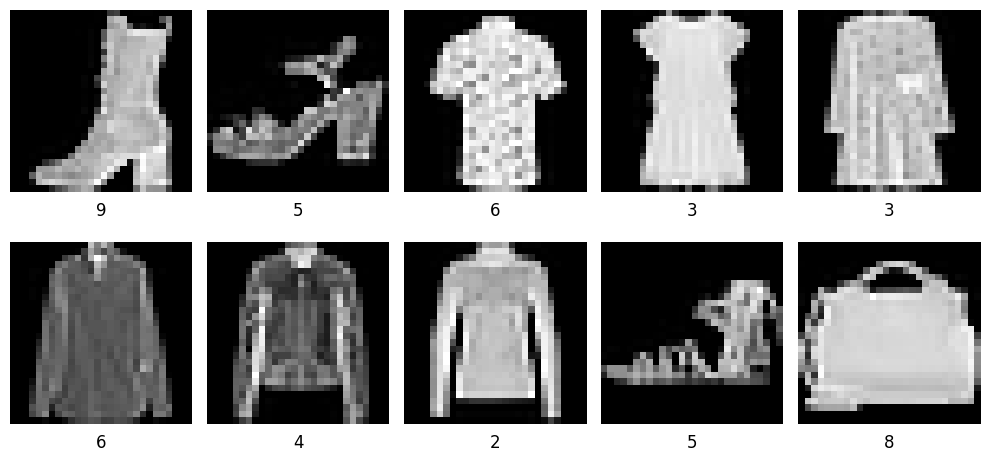

In [2]:
# Codegrade Tag Question1
# Do *not* remove the tag above

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,     batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Sample 10 images from the training set
images, labels = next(iter(train_loader))  # images: [B, 1, 28, 28], labels: [B]
images = images[:10]    # take first 10
labels = labels[:10]

# Rescale from [-1, 1] back to [0, 1]
images_rescaled = (images + 1) / 2  # still shape [10, 1, 28, 28]

# Plot a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
ax = axs.ravel()

for i in range(10):
    img = images_rescaled[i].squeeze(0).cpu().numpy()  # [28, 28]
    ax[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    ax[i].axis('off')  
    ax[i].set_title(str(int(labels[i])), y=-0.18)  # Title underneath each image with numeric label

plt.tight_layout()
plt.show()

## Question 2: Simple neural network

In this question, we construct a simple neural network with one fully-connected hidden layer of 64 nodes. We will then train and evaluate it on the dataset.

### Question 2a

Implement the following class `SimpleNN` according to the following specification:
- The network shall take in the $n\times n$ images as input (`input_size`)
- There shall be a single fully-connected hidden layer of specified size $m$ (`hidden_size`)
- The network shall output $k$ values (`output_size`)
- The activation function shall be [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))

Construct then an instance called `simple_nn` such that it takes in $28\times 28$ images, has exactly 64 hidden units, and outputs 10 values (one for each class).

**Hints:**
- `input_size` is the total number of inputs, that is, the number of elements in the **flattened vector** corresponding to the image; for an image of $n\times n$ pixels, there would be $n^2$ inputs

In [3]:
# Codegrade Tag Question2a
# Do *not* remove the tag above

import torch.nn as nn
import torch

class SimpleNN(nn.Module):
    """
    A simple neural network with one fully connected layer.
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        Construct the layers.
        Parameters:
        - input_size: the size of the input images (flattened!)
        - hidden_size: number of neurons in the hidden layer
        - output_size: number of output neurons (i.e., the number of class labels)
        """
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Evaluate the network for the input x.
        """
        x = torch.flatten(x, start_dim=1)   # flatten to [batch_size, input_size]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # logits

        return x

simple_nn = SimpleNN(input_size = 28*28, hidden_size = 64, output_size = 10)

## Question 2b

Implement the following function called `train_one_epoch` according to the following specification:
- The function shall train `model` using the data from the `loader` (which should provide the training set) **for one epoch**, using the `loss_fn` object for loss criterion and the `optimizer` object for optimizer.
- As return value, the function shall return a tuple that has the mean training loss for the epoch as the first value and the training accuracy as the second.

The function will also be used later on as a building block for more complicated functions. Also, the function will be used with more complicated models, so remember to set the model into training mode; otherwise training the more complicated functions may fail.

Do not include any expensive computations in this cell outisde the function definition because this cell will be used by all future questions.

**Hints:**
- The structure is simple: iterate through the training set and for each iteration, zero the gradient of the optimizer, compute the loss, perform backpropagation, and then step the optimizer
- Remember to collect the statistics (loss and accuracy)!
- The output of the model is a vector of values, the elements of which are proportional to the probability of the observation coming from a class; select the index of the maximum value to make the classification, then compare it to the correct class label in order to compute accuracy

In [4]:
# Codegrade Tag Question2b
# Do *not* remove the tag above

import torch.optim as optim

def train_one_epoch(model, loader, loss_fn, optimizer):
    """
    Train the model using the data from loader for one epoch.
    
    Parameters:
    - model: nn.Model, the model to train
    - loader: Dataloader, the training dataset
    - loss: the loss function
    - optimizer: optim.Optimizer, the optimizer to use
    
    Return value:
    - A tuple (mean_loss,accuracy) where mean_loss is the average loss over the 
    epoch and accuracy is the training accuracy (correct classifications of the 
    training set / number of items in the training set)
    """
    model.train()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Infer device from model (fallback to CPU if model has no params yet)
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")

    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        # Accumulate stats
        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        total_correct += (preds == targets).sum().item()
        total_samples += batch_size

    mean_loss = total_loss / max(total_samples, 1)
    accuracy = total_correct / max(total_samples, 1)

    return mean_loss, accuracy

## Question 2c

Implement the following function called `evaluate` according to the following specification:
- The function shall evaluate `model` using the data from the `loader` (which should provide the validation or the test set).
- The function shall return a tuple `(loss,accuracy)` that contains the loss and classification accuracy with respect to the set in question.

We do not want to update the gradient values, so set the model in evaluation mode.

Do not include any expensive computations in this cell outisde the function definition because this cell will be used by all future questions.

**Hints:**
- The basic structure is the same as in training, but we now just set the model into evaluation mode, use `torch.no_grad()` to suppress gradient computation, and needn't call an optimizer or perform backpropagation.

In [5]:
# Codegrade Tag Question2c
# Do *not* remove the tag above

def evaluate(model, loader, loss_fn):
    """
    Evaluates the model against the dataset provided by loader with respect to the loss function.
    
    Parameters:
    - model: nn.Model, the model to train
    - loader: Dataloader, the training dataset
    - loss: the loss function
    
    Return value:
    - A tuple (mean_loss,accuracy) where mean_loss is the average loss over the dataset and
    accuracy is the validation/test accuracy (correct classifications / number of items in the set)
    """
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Infer device from model (fallback to CPU if no params)
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            batch_size = inputs.size(0)
            total_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            total_correct += (preds == targets).sum().item()
            total_samples += batch_size

    mean_loss = total_loss / max(total_samples, 1)
    accuracy = total_correct / max(total_samples, 1)

    return mean_loss, accuracy

## Question 2d

Implement the following function called `train` according to the following specification:
- The function shall train the `model` for the given number of epochs using `train_one_epoch` function, with the Adam optimizer and using CrossEntropyLoss for the loss function
- At the end of each epoch, the model shall be evaluated against the validation set using the `evaluate` function
- The function shall return a 4-tuple of lists `(train_losses,train_accuracies,val_losses,val_accuracies)` that contains the training and validation losses and accuracies per each epoch; that is, four lists with the number of elements corresponding to the number of epochs.

Do not include any expensive computations in this cell outisde the function definition because this cell will be used by all future questions.

This function will also be manually inspected by a TA.

**Hints:**
- The basic structure is the same as in training, but we now just set the model into evaluation mode, use `torch.no_grad()` to suppress gradient computation, and needn't call an optimizer or perform backpropagation.

In [6]:
# Codegrade Tag Question2d
# Do *not* remove the tag above

def train(model, train_loader, val_loader, num_epochs, learning_rate = 0.0001):
    """
    Trains the model using Adam optimizer and Cross Entropy Loss for the given 
    number of epochs against the training set.
    After each epoch, evaluates the model against the validation set.
    
    Returns a 4-tuple (train_losses,train_accuracies,val_losses,val_accuracies)
    """
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, loss_fn, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn)

        print(f"Epoch: {epoch + 1}")
        print(f"Training Loss: {tr_loss:.4f} | Validation Loss: {val_loss:.4f}")
        print(f"Training Accuracy: {tr_acc:.4f} | Validation Accuracy: {val_acc:.4f}")
        print(f"-------------------------------------------------------")
        train_losses.append(tr_loss)
        train_accuracies.append(tr_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    return train_losses, train_accuracies, val_losses, val_accuracies

## Question 2e

Train the model for at least 10 epochs using the training data. Store the `state_dict` of the trained model in a file called `simple_nn.pt`.

Use matplotlib to plot the **training and validation accuracies** as a function of the epoch number. Include a legend tell which is which.

**Important.** Since training models is very expensive, **the code in the next cell will be removed from further consideration by the autograder**. So, make sure no future cell depends on any code in that cell! This is why you will submit the model weights in a separate file.

When submitting your answers, you will need to submit all `.pt` files produced when training together with the notebook.

You should be able to reach a training accuracy in excess of 86%.

**Hints:**
- See: https://pytorch.org/tutorials/beginner/saving_loading_models.html

Epoch: 1
Training Loss: 0.8583 | Validation Loss: 0.5959
Training Accuracy: 0.7322 | Validation Accuracy: 0.7931
-------------------------------------------------------
Epoch: 2
Training Loss: 0.5335 | Validation Loss: 0.5171
Training Accuracy: 0.8151 | Validation Accuracy: 0.8225
-------------------------------------------------------
Epoch: 3
Training Loss: 0.4801 | Validation Loss: 0.4790
Training Accuracy: 0.8318 | Validation Accuracy: 0.8319
-------------------------------------------------------
Epoch: 4
Training Loss: 0.4521 | Validation Loss: 0.4622
Training Accuracy: 0.8409 | Validation Accuracy: 0.8372
-------------------------------------------------------
Epoch: 5
Training Loss: 0.4336 | Validation Loss: 0.4501
Training Accuracy: 0.8476 | Validation Accuracy: 0.8421
-------------------------------------------------------
Epoch: 6
Training Loss: 0.4197 | Validation Loss: 0.4365
Training Accuracy: 0.8530 | Validation Accuracy: 0.8457
------------------------------------------

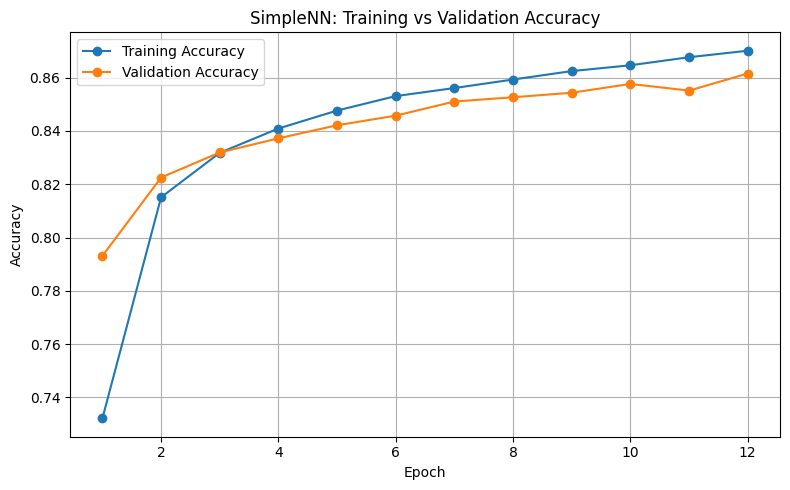

In [7]:
# Codegrade Tag Question2e
# Do *not* remove the tag above

import torch
import matplotlib.pyplot as plt

# Device & model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_nn.to(device)

# Train for at least 10 epochs
num_epochs = 12
train_losses, train_accuracies, val_losses, val_accuracies = train(simple_nn, train_loader, val_loader, num_epochs)

# Save trained weights
torch.save(simple_nn.state_dict(), "simple_nn.pt")

# Plot training & validation accuracies
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, marker = "o", label = "Training Accuracy")
plt.plot(epochs, val_accuracies, marker = "o", label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("SimpleNN: Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 2f

Load the weights of your model from the file `simple_nn.pt` into a model stored in a variable called `simple_nn` and compute the accuracy with respect to the test set (using `test_loader`), using the function `evaluate` you defined in the previous cell. Store the accuracy in a variable called `test_accuracy_simple`.

Your model should be able to reach a test accuracy of 84%.

**Important.** You must load the model from a file because the cell for Question 2c is ignored by the autograder. Also, this cell will be ignored by the grader in later questions, so future cells should not depend on code in this cell.

**Hints:**
- In order to load the `state_dict`, you need to (i) instantiate an object of the class `SimpleNN` with correct parameters, then use the method `load_state_dict` and pass the content of `torch.load` of your function (see [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for help)

In [24]:
# Codegrade Tag Question2f
# Do *not* remove the tag above

import torch
import torch.nn as nn

# Recreate the model architecture
simple_nn = SimpleNN(input_size=28*28, hidden_size=64, output_size=10)

# Load weights onto the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_nn.load_state_dict(torch.load("simple_nn.pt", map_location = device))
simple_nn.to(device)

# Evaluate on the test set
loss_fn = nn.CrossEntropyLoss()
test_loss_simple, test_accuracy_simple = evaluate(simple_nn, test_loader, loss_fn)

print(f"SimpleNN Test Accuracy: {test_accuracy_simple:.4f}")

SimpleNN Test Accuracy: 0.8511


## Question 3: Two-layer perceptron

We will now construct a two-layer perceptron with a specified number of units.

### Question 3a:

Implement the following class `TwoLayerNN` according to the following specification:
- The network shall take in the $n\times n$ images as input (`input_size`)
- There shall be a two fully-connected hidden layer of specified size $m_1,m_2$ (`hidden_sizes` is a 2-tuple of integers)
- Each fully connected hidden layer shall be followed by a dropout layer that removes the connection with probability $p$ (`dropout_prob`)
- The network shall output $k$ values (`output_size`)
- The activation function shall be [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))

Then, instantiate an object called `two_layer_nn` that takes the $28\times 28$ greyscale images as input, has 512 and 256 units in the hidden layers, respectively, has dropout probability $p=0.2$, and 10 outputs.

The architecture is also shown in the image below.

![Two-layer architecture](two_layer_architecture.png)

In [9]:
# Codegrade Tag Question3a
# Do *not* remove the tag above

import torch
import torch.nn as nn

class TwoLayerNN(nn.Module):
    """
    A simple neural network with two fully connected hidden layers, 
    each of which is followed by a dropout layer.
        """
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob):
        """
        Constructor.        
        Parameters:
        - input_size: integer, the flattened vector size of inputs
        - hidden_sizes: a tuple of two integers, the sizes of the two hidden layers
        - output_size: number of outputs (number of classes)
        - dropout_prob: float, probability parameter for the dropout layers
        """
        super().__init__()
        h1, h2 = hidden_sizes

        self.fc1 = nn.Linear(input_size, h1)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(h1, h2)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc_out = nn.Linear(h2, output_size)
        self.relu = nn.ReLU()

    
    def forward(self, x):
        """
        Evaluates the network for the given argument x.
        """
        x = torch.flatten(x, start_dim=1)   # [batch, input_size]
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc_out(x)  # logits
        return x

two_layer_nn = TwoLayerNN(input_size = 28 * 28, hidden_sizes = (512, 256), output_size = 10, dropout_prob = 0.2)

### Question 3b

Use the `train` function we defined earlier and train the two-layer model with respect to the training set for at least 10 epochs. Plot the training and validation accuracies as function of the epochs, just like in Questio 2e. Save the trained model in a file called `two_layer_nn.pt`.

You should be able to reach a training accuracy in the excess of 89%.

**Important.** The content of the following cell is removed from the notebook by the grader, so make sure no further cells depend on any code in the cell.

Epoch: 1
Training Loss: 0.5332 | Validation Loss: 0.4412
Training Accuracy: 0.8052 | Validation Accuracy: 0.8339
-------------------------------------------------------
Epoch: 2
Training Loss: 0.4080 | Validation Loss: 0.3883
Training Accuracy: 0.8510 | Validation Accuracy: 0.8566
-------------------------------------------------------
Epoch: 3
Training Loss: 0.3714 | Validation Loss: 0.3841
Training Accuracy: 0.8636 | Validation Accuracy: 0.8637
-------------------------------------------------------
Epoch: 4
Training Loss: 0.3509 | Validation Loss: 0.3477
Training Accuracy: 0.8708 | Validation Accuracy: 0.8739
-------------------------------------------------------
Epoch: 5
Training Loss: 0.3337 | Validation Loss: 0.3615
Training Accuracy: 0.8775 | Validation Accuracy: 0.8691
-------------------------------------------------------
Epoch: 6
Training Loss: 0.3188 | Validation Loss: 0.3352
Training Accuracy: 0.8816 | Validation Accuracy: 0.8805
------------------------------------------

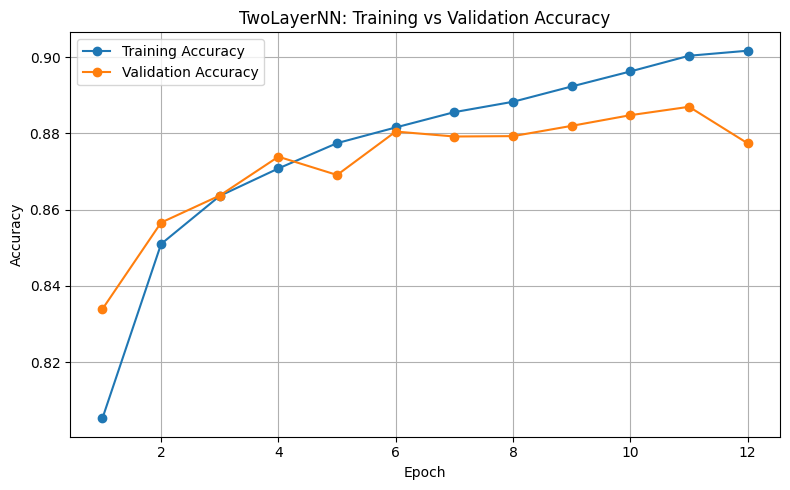

In [ ]:
# Codegrade Tag Question3b
# Do *not* remove the tag above

import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
two_layer_nn.to(device)

num_epochs = 12
train_losses_perc, train_accuracies_perc, val_losses_perc, val_accuracies_perc = train(two_layer_nn, train_loader, val_loader, num_epochs)

torch.save(two_layer_nn.state_dict(), "two_layer_nn.pt")

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies_perc, marker = "o", label = "Training Accuracy")
plt.plot(epochs, val_accuracies_perc, marker = "o", label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("TwoLayerNN: Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Question 3c

Load the model you trained from `two_layer_nn.pt` into a variable called `two_layer_nn`. Then, use the `evaluate` function we defined earlier to compute the accuracy with respect to the test set and store the accuracy in `test_accuracy_two_layer`.

Your model should be able to reach an accuracy of 87%.

**Important.** You must load the model from a file because the cell for Question 3b is ignored by the autograder. Also, this cell will be ignored by the grader in later questions, so future cells should not depend on code in this cell.


In [23]:
# Codegrade Tag Question3c
# Do *not* remove the tag above

import torch
import torch.nn as nn

# Recreate the architecture and load trained weights
two_layer_nn = TwoLayerNN(input_size = 28*28, hidden_sizes = (512, 256), output_size = 10, dropout_prob = 0.2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
two_layer_nn.load_state_dict(torch.load("two_layer_nn.pt", map_location=device))
two_layer_nn.to(device)

# Evaluate on the test set
loss_fn = nn.CrossEntropyLoss()
test_loss_two_layer, test_accuracy_two_layer = evaluate(two_layer_nn, test_loader, loss_fn)

print(f"TwoLayerNN Test Accuracy: {test_accuracy_two_layer:.4f}")

TwoLayerNN Test Accuracy: 0.8716


## Question 4: Convolutional Neural Network

Finally, we train a convolutional neural network to classify the objects.

### Question 4a

Implement the neural network according to the following diagram.

![convolutional architecture](convolutional_architecture.png)

**Note.** If you find the image difficult to read, open the file `convolutional_architecture.png` manually.

Instantiate the network in a variable called `cnn`.

In [16]:
# Codegrade Tag Question4a
# Do *not* remove the tag above

import torch
import torch.nn as nn
import math

class CNN(nn.Module):
    """
    A convolutional neural network with three convolutional layers (each contains a batch normalization, 
    relu activation, followed by max pooling),
    flattening, followed by three fully connected layers (the first two followed by dropouts)
    """
    def __init__(self, in_sizes, in_channels, conv1_channels, conv2_channels, conv3_channels, 
                 kernel_size, padding, pool_size, fc1_size, fc2_size, out_size, dropout_probability):
        """
        Parameters:
        - in_sizes: (width,height) tuple for image dimensions
        - in_channels: integer, number of input channels (1 for greyscale)
        - conv1_channels, conv2_channels, conv3_channels: integer, output channels for the convolutional layer
        - kernel_size: integer, shared kernel size for all convolutional layers
        - padding: integer, shared padding for all convolutional layers
        - fc1_size, fc2_size: integer, number of neurons in the fully connected layers
        - out_size: integer, output layer size (number of classes)
        - dropout_probability: float, shared dropout probability for fully connected layers
        """
        super().__init__()
        W, H = in_sizes

        # Convolutional blocks
        self.conv1 = nn.Conv2d(in_channels, conv1_channels, kernel_size=kernel_size, padding=padding, stride=1, bias=True)
        self.bn1   = nn.BatchNorm2d(conv1_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size)

        self.conv2 = nn.Conv2d(conv1_channels, conv2_channels, kernel_size=kernel_size, padding=padding, stride=1, bias=True)
        self.bn2   = nn.BatchNorm2d(conv2_channels)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size)

        self.conv3 = nn.Conv2d(conv2_channels, conv3_channels, kernel_size=kernel_size, padding=padding, stride=1, bias=True)
        self.bn3   = nn.BatchNorm2d(conv3_channels)
        self.pool3 = nn.MaxPool2d(kernel_size=pool_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=dropout_probability)
        self.dropout2 = nn.Dropout(p=dropout_probability)

        # Compute flattened size after conv/pool stack
        def conv_out_size(size, k, p, s=1, d=1):
            return math.floor((size + 2*p - d*(k-1) - 1)/s + 1)

        def pool_out_size(size, k, s=None, p=0, d=1):
            if s is None:
                s = k
            return math.floor((size + 2*p - d*(k-1) - 1)/s + 1)

        # After conv1 + pool1
        W1 = pool_out_size(conv_out_size(W, kernel_size, padding), pool_size)
        H1 = pool_out_size(conv_out_size(H, kernel_size, padding), pool_size)
        # After conv2 + pool2
        W2 = pool_out_size(conv_out_size(W1, kernel_size, padding), pool_size)
        H2 = pool_out_size(conv_out_size(H1, kernel_size, padding), pool_size)
        # After conv3 + pool3
        W3 = pool_out_size(conv_out_size(W2, kernel_size, padding), pool_size)
        H3 = pool_out_size(conv_out_size(H2, kernel_size, padding), pool_size)

        flattened = conv3_channels * W3 * H3

        # Fully connected head
        self.fc1 = nn.Linear(flattened, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, out_size)

    def forward(self, x):
        """
        Evaluates the network
        """
        # Block 1
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # FC head
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # logits
        return x

cnn = CNN(
    in_sizes=(28, 28), in_channels=1, conv1_channels=32, 
    conv2_channels=64, conv3_channels=128, kernel_size=3,
    padding=1, pool_size=2, fc1_size=256,
    fc2_size=128, out_size=10, dropout_probability=0.5
)

### Question 4b

Use the `train` function we defined earlier and train the CNN model with respect to the training set for at least 10 epochs. Plot the training accuracy as function of the epochs. Save the trained model in a file called `cnn.pt`.

Your model should be able to reach a training accuracy of over 93%.

**Important.** The content of the following cell is removed from the notebook by the grader, so make sure no further cells depend on any code in the cell.

/Users/redseason/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1
Training Loss: 0.8430 | Validation Loss: 0.4187
Training Accuracy: 0.7082 | Validation Accuracy: 0.8533
-------------------------------------------------------
Epoch: 2
Training Loss: 0.4405 | Validation Loss: 0.3336
Training Accuracy: 0.8486 | Validation Accuracy: 0.8782
-------------------------------------------------------
Epoch: 3
Training Loss: 0.3579 | Validation Loss: 0.2864
Training Accuracy: 0.8759 | Validation Accuracy: 0.8953
-------------------------------------------------------
Epoch: 4
Training Loss: 0.3160 | Validation Loss: 0.2782
Training Accuracy: 0.8920 | Validation Accuracy: 0.8993
-------------------------------------------------------
Epoch: 5
Training Loss: 0.2825 | Validation Loss: 0.2695
Training Accuracy: 0.9025 | Validation Accuracy: 0.9017
-------------------------------------------------------
Epoch: 6
Training Loss: 0.2626 | Validation Loss: 0.2544
Training Accuracy: 0.9094 | Validation Accuracy: 0.9065
------------------------------------------

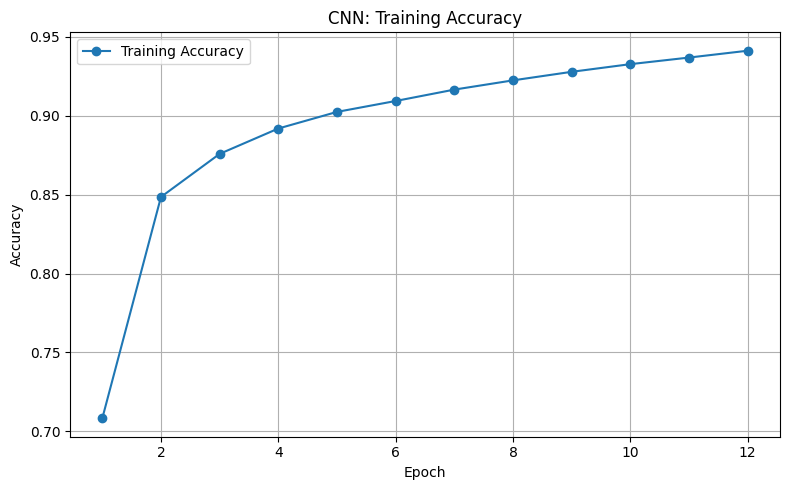

In [ ]:
# Codegrade Tag Question4b
# Do *not* remove the tag above

import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)

num_epochs = 12
train_losses_cnn, train_accuracies_cnn, val_losses_cnn, val_accuracies_cnn = train(cnn, train_loader, val_loader, num_epochs)

torch.save(cnn.state_dict(), "cnn.pt")

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies_cnn, marker="o", label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN: Training Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Question 4c

Load the model you trained from `cnn.pt` into a variable called `cnn`. Then, use the `evaluate` function we defined earlier to compute the accuracy with respect to the test set and store the accuracy in `test_accuracy_cnn`.

Your model should be able to reach a test accuracy of over 90%.

In [22]:
# Codegrade Tag Question4c
# Do *not* remove the tag above

import torch
import torch.nn as nn

# Recreate the architecture and load trained weights
cnn = CNN(
    in_sizes=(28, 28), in_channels=1, conv1_channels=32, 
    conv2_channels=64, conv3_channels=128, kernel_size=3,
    padding=1, pool_size=2, fc1_size=256,
    fc2_size=128, out_size=10, dropout_probability=0.5
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.load_state_dict(torch.load("cnn.pt", map_location=device))
cnn.to(device)

# Evaluate on the test set
loss_fn = nn.CrossEntropyLoss()
test_loss_cnn, test_accuracy_cnn = evaluate(cnn, test_loader, loss_fn)

print(f"CNN Test Accuracy: {test_accuracy_cnn:.4f}")

CNN Test Accuracy: 0.9093


## Question 5

Discuss the three different models and how they performed. What can you tell from the plotted training accuracies? Do the models over or underfit? In economics, one often considers [the law of diminishing returns](https://en.wikipedia.org/wiki/Diminishing_returns). Is this an appropriate analogy? What kind of similarities can you observe in the training of neural networks?

Write 1 or 2 paragraphs.

*Write your answer here*

Among all the models to their own training accuracy plot, we can say there is a rank about their performance. Simple neural network has the lowest accuracy, two-layer perceptron is the scond, and the CNN is the best compared to other models. As a matter of fact, they do not face underfitting condition, they might encounter overfitting though because of the gap between the training accuracy and the validation accuracy, and that would be resolved by not only dropout but weighted parameters like LASSO.

Across all three plots, the curves show fast early gains followed by smaller and tapering improvements, which is very much like diminishing returns in economics. Each additional epoch yields less incremental accuracy once the model has learned the most significant patterns.